In [725]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster

from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin, accuracy_score, confusion_matrix,silhouette_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from kneed import KneeLocator

from sklearn import datasets


import numpy as np
import os

NUM_THREADS = '1'
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS
import warnings

warnings.filterwarnings('ignore')

In [726]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

In [727]:
def normalization(df, target):
    df[target] = df[target] / df[target].max()


([<matplotlib.axis.YTick at 0x2c44bded250>,
 [Text(0, 0.5, 'exports'),
  Text(0, 1.5, 'health'),
  Text(0, 2.5, 'imports'),
  Text(0, 3.5, 'income'),
  Text(0, 4.5, 'inflation'),
  Text(0, 5.5, 'life_expec'),
  Text(0, 6.5, 'total_fer'),
  Text(0, 7.5, 'gdpp')])

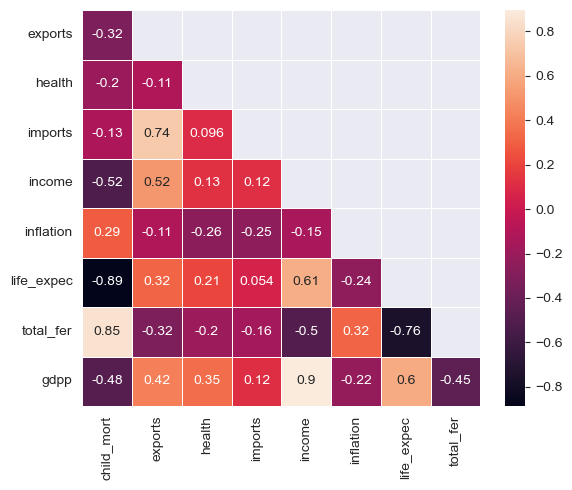

In [728]:

raw_data = pd.read_csv('dataset/Country-data.csv')

df = raw_data.copy()

cors = np.ones_like(df.corr(), dtype=bool)
mask = np.triu(cors)
mask = mask[1:, :-1]

plt.figure(figsize=(6,5))
plt.rcParams["figure.autolayout"] = True

df_corr = df.corr().iloc[1:,:-1]
sns.heatmap(df_corr, annot=True, linewidth=0.4, mask=mask)
plt.yticks(plt.yticks()[0], labels=df_corr.index,rotation=0)


In [729]:

data = MinMaxScaler().fit_transform(raw_data.drop(["country"], axis=1))
data = pd.DataFrame(data, columns=raw_data.columns[1:], index=raw_data.index)
data.insert(0, "country", raw_data.country.to_list())

data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.173661,0.205112,0.311106,0.269207,0.132933,0.110820,0.758495,0.283591,0.121536
std,0.196343,0.137135,0.170717,0.139188,0.154980,0.097687,0.175408,0.238777,0.174944
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027507,0.118520,0.193288,0.173250,0.022076,0.055633,0.654832,0.101735,0.010490
50%,0.081305,0.174550,0.280298,0.248566,0.075174,0.088716,0.808679,0.198738,0.042274
75%,0.289679,0.256345,0.422001,0.337393,0.178397,0.138250,0.881657,0.430599,0.131900
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [730]:
data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,Albania,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,Algeria,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,Angola,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,Antigua and Barbuda,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143
163,Venezuela,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650
164,Vietnam,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299
165,Yemen,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299


In [731]:
gdpp = data[["income", "gdpp"]]
gdpp

,income,gdpp
0,0.008047,0.003073
1,0.074933,0.036833
2,0.098809,0.040365
3,0.042535,0.031488
4,0.148652,0.114242
...,...,...
162,0.018820,0.026143
163,0.127750,0.126650
164,0.031200,0.010299
165,0.031120,0.010299


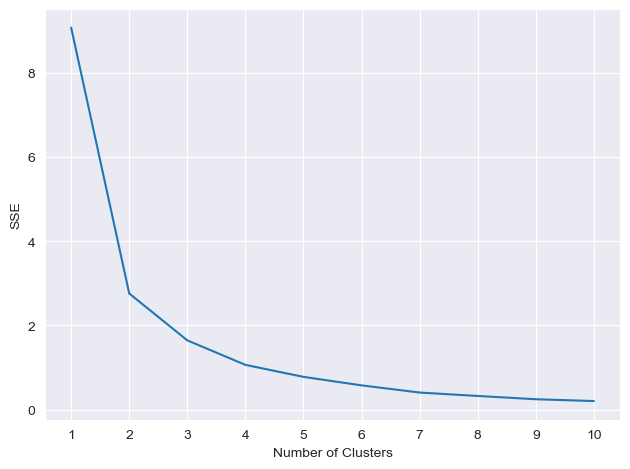

3

In [732]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,random_state=0).fit(gdpp)
    # kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
kl.elbow


In [733]:
def find_optimal_number_cluster(group):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(group)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    return kl.elbow

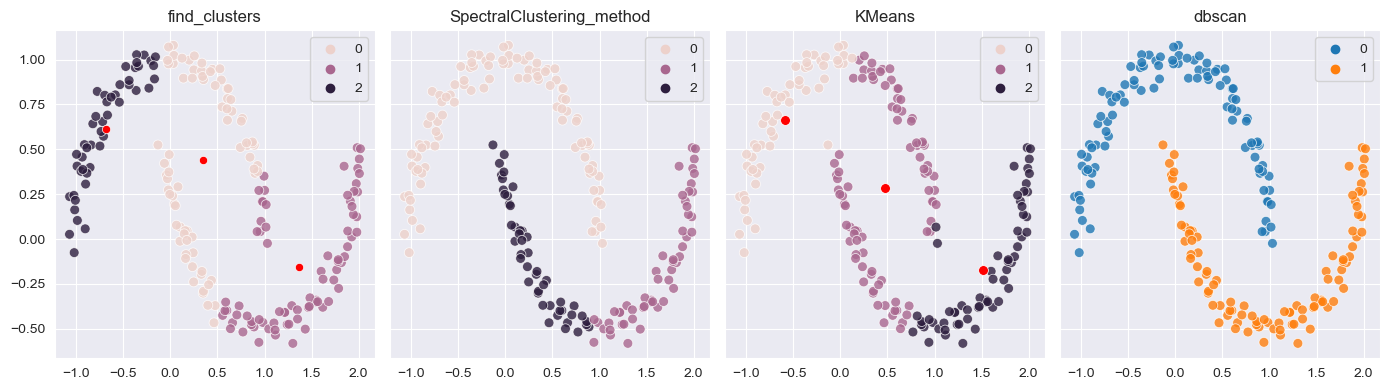

In [734]:
from sklearn.datasets import make_moons

x, y = make_moons(200, noise=.05, random_state=0)


def clustering_four_methods(data,eps =0.3,min_sample=5):
    xlabel, ylabel = "x", "y"
    if type(data) == pd.core.frame.DataFrame:
        xlabel, ylabel = data.keys()
        X = np.array(data.values.tolist())
    else:
        X = data
    global KMeans

    NUMBER_CLUSTER = find_optimal_number_cluster(X)

    SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors',
                                                           assign_labels='kmeans')
    KMean_data = KMeans(NUMBER_CLUSTER, random_state=0).fit(X)
    KMeans_centers = KMean_data.cluster_centers_
    dbscan = cluster.DBSCAN(eps=eps,min_samples=min_sample).fit(X)
    # print(dbscan.labels_)
    centers, labels_find = find_clusters(X, NUMBER_CLUSTER, rseed=0)
    labels_spectral = SpectralClustering_method.fit_predict(X)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True)
    ax1.set_title("find_clusters")
    ax2.set_title("SpectralClustering_method")
    ax3.set_title("KMeans")
    ax4.set_title("dbscan")
    sns.scatterplot(X[:, 0], X[:, 1], x=xlabel, y=ylabel, alpha=0.8, c=labels_find, s=50, ax=ax1, hue=labels_find)
    sns.scatterplot(centers[:, 0], centers[:, 1], color='red', s=35, alpha=1, ax=ax1);
    sns.scatterplot(X[:, 0], X[:, 1], alpha=0.8, x=xlabel, y=ylabel, c=labels_spectral, s=50, ax=ax2,
                    hue=labels_spectral)
    sns.scatterplot(X[:, 0], X[:, 1], alpha=0.8, x=xlabel, y=ylabel, c=KMean_data.labels_, s=50, ax=ax3,
                    hue=KMean_data.labels_)
    sns.scatterplot(KMeans_centers[:, 0], KMeans_centers[:, 1], color='red', s=50, alpha=1, ax=ax3);
    sns.scatterplot(X[:, 0], X[:, 1], alpha=0.8, c=dbscan.labels_, x=xlabel, y=ylabel, s=50, ax=ax4, hue=dbscan.labels_)


clustering_four_methods(x)


In [735]:
gdpp.keys()
xlabel, ylabel = gdpp.keys()
print(xlabel + "ylabe=" + ylabel)

incomeylabe=gdpp


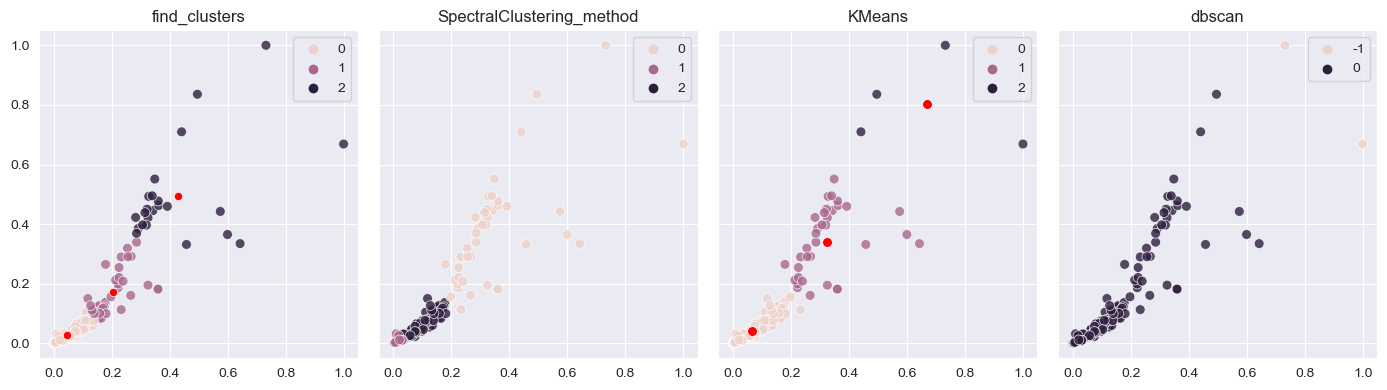

In [736]:
# gdpp
clustering_four_methods(gdpp)


,income,gdpp
37,0.000000,0.000983
88,0.000732,0.000916
26,0.001246,0.000000
112,0.001648,0.001117
31,0.002243,0.002052
...,...,...
133,0.574728,0.442583
82,0.599649,0.365270
23,0.643061,0.334727
91,0.732296,1.000000


,income,gdpp
37,0.000000,0.000983
88,0.000732,0.000916
26,0.001246,0.000000
112,0.001648,0.001117
31,0.002243,0.002052
...,...,...
133,0.574728,0.442583
82,0.599649,0.365270
23,0.643061,0.334727
91,0.732296,1.000000


,index,distance


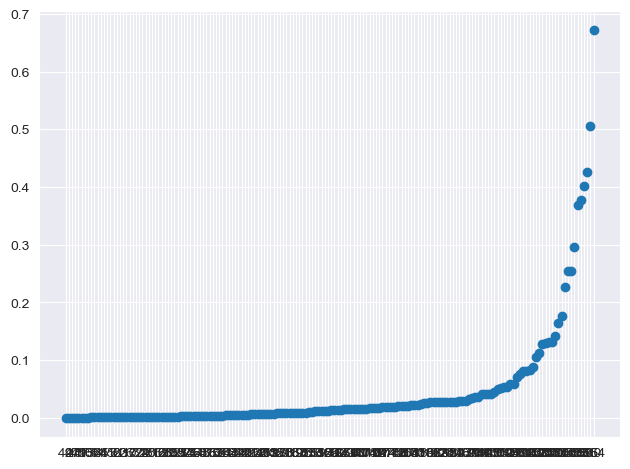

In [737]:

income_gdpp_sorted = gdpp.sort_values(by=["income", "gdpp"])
display(income_gdpp_sorted)

normalization(income_gdpp_sorted,"income")
normalization(income_gdpp_sorted,"gdpp")

display(income_gdpp_sorted)

distance_df = pd.DataFrame(columns=["index", "distance"])
display(distance_df)

for i in range(0, len(income_gdpp_sorted) - 1):
    dist = np.linalg.norm(income_gdpp_sorted.iloc[i] - income_gdpp_sorted.iloc[i + 1])
    distance_df = distance_df.append({'index': str(i), 'distance': dist}, ignore_index=True)
distance_df = distance_df.sort_values(by=["distance"])
plt.scatter(distance_df["index"], distance_df["distance"])
plt.show()

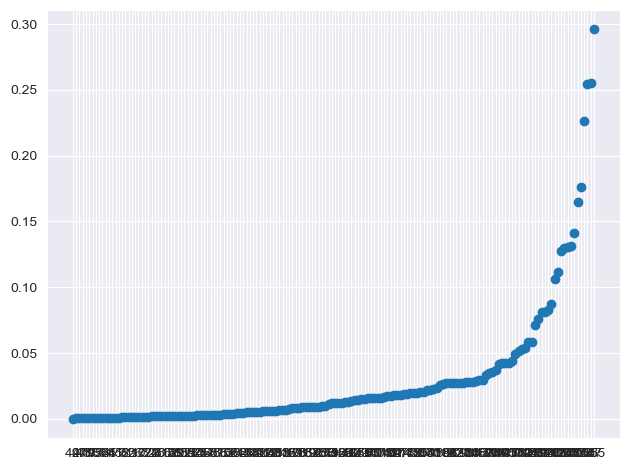

In [738]:
distance_df2 = distance_df[distance_df['distance'] < 0.35]
distance_df2 = distance_df2.sort_values(by=["distance"])
plt.scatter(distance_df2["index"], distance_df2["distance"])
plt.show()

In [739]:
import sklearn

range_eps = (0.05 + x * 0.05 for x in range(5))
for i in range_eps:
    db = cluster.DBSCAN(eps=i, min_samples=5).fit(income_gdpp_sorted)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    print(set(labels))
    silhoutte_avg = silhouette_score(income_gdpp_sorted, labels)
    print(f"For eps={i} average silhouette score is {silhoutte_avg}")

{0, 1, -1}
For eps=0.05 average silhouette score is 0.6396721968588549
{0, -1}
For eps=0.1 average silhouette score is 0.699308923212576
{0, -1}
For eps=0.15000000000000002 average silhouette score is 0.7122904872528605
{0, -1}
For eps=0.2 average silhouette score is 0.7567871776306927
{0, -1}
For eps=0.25 average silhouette score is 0.7685924011606775


In [740]:
min_samples = [1,2,3,4,5,6,7,8,9,10,11
               ,12,13,14,15,16,17,18,19,20,21]
for i in min_samples:
    print("min sample "+ str(i))
    db = cluster.DBSCAN(eps=0.1, min_samples=i).fit(income_gdpp_sorted)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = set([label for label in db.labels_ if label >=0])
    print(set(labels))
    print(f"For min sample value ="+ str(i) + " Total no. of cluster are " +str(len(set(labels))))

    # silhoutte_avg = silhouette_score(income_gdpp_sorted, labels)


min sample 1
{0, 1, 2, 3, 4, 5, 6}
For min sample value =1 Total no. of cluster are 7
min sample 2
{0, 1}
For min sample value =2 Total no. of cluster are 2
min sample 3
{0, 1}
For min sample value =3 Total no. of cluster are 2
min sample 4
{0}
For min sample value =4 Total no. of cluster are 1
min sample 5
{0}
For min sample value =5 Total no. of cluster are 1
min sample 6
{0}
For min sample value =6 Total no. of cluster are 1
min sample 7
{0}
For min sample value =7 Total no. of cluster are 1
min sample 8
{0}
For min sample value =8 Total no. of cluster are 1
min sample 9
{0}
For min sample value =9 Total no. of cluster are 1
min sample 10
{0}
For min sample value =10 Total no. of cluster are 1
min sample 11
{0}
For min sample value =11 Total no. of cluster are 1
min sample 12
{0}
For min sample value =12 Total no. of cluster are 1
min sample 13
{0, 1}
For min sample value =13 Total no. of cluster are 2
min sample 14
{0, 1}
For min sample value =14 Total no. of cluster are 2
min samp

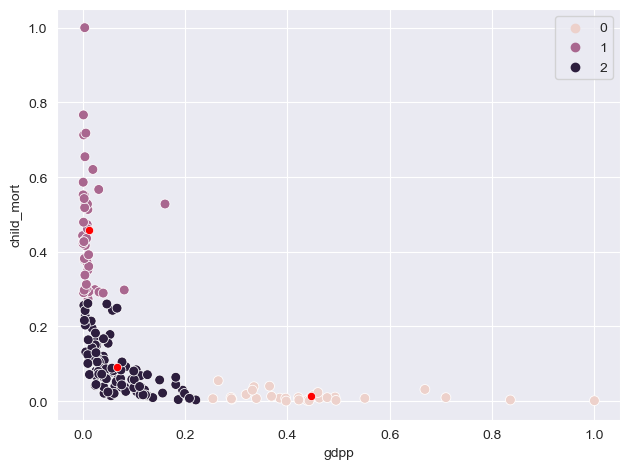

In [741]:

results = pd.DataFrame(data.country, columns=["country"])

def cluster(df, target, y, method=1, eps =0.3, min_sample=5, count_cluster = None):
    df_result = pd.DataFrame(data.country, columns=["country"])
    if target != y and df[y].dtypes != object:
            group = df[[target, y]]
            X = np.array(group.values.tolist())
            if(count_cluster == None):
                count_cluster = find_optimal_number_cluster(X)
            if (method == 0):
                centers, labels = find_clusters(X, count_cluster, rseed=0)
                key = 'cluster_param_' + target + "_" + y
                df_result[key] = labels
                df[key] = labels
                sns.scatterplot(data=df, x=target, y=y, alpha=0.8, c=labels, s=50, hue=labels)
                sns.scatterplot(centers[:, 0], centers[:, 1], color='red', s=35, alpha=1);

            if (method == 1):
                SpectralClustering_method = cluster.SpectralClustering(n_clusters=count_cluster,affinity='nearest_neighbors',assign_labels='kmeans')
                labels = SpectralClustering_method.fit_predict(X)
                key = 'cluster_param_' + target + "_" + y
                df_result[key] = labels
                df[key] = labels
                sns.scatterplot(X[:, 0], X[:, 1], alpha=0.8, x=target, y=y, c=labels, s=50,
                                hue=labels)
                # sns.scatterplot(data=df, x=target, y=y_label, alpha=0.8, c=labels, s=50, ax=axes[index], hue=labels)
            if (method == 2):
                KMean_data = KMeans(count_cluster, random_state=0).fit(X)
                centers = KMean_data.cluster_centers_
                labels = KMean_data.labels_
                key = 'cluster_param_' + target + "_" + y
                df_result[key] = labels
                df[key] = labels
                sns.scatterplot(data=df, x=target, y=y, alpha=1, c=labels, s=50,  hue=labels)
                sns.scatterplot(centers[:, 0], centers[:, 1], color='red', s=35, alpha=1,);

            if (method == 3):
                dbscan = cluster.DBSCAN(eps=eps,min_samples=min_sample).fit(X)
                labels = dbscan.labels_
                key = 'cluster_param_' + target + "_" + y
                df_result[key] = labels
                df[key] = labels
                sns.scatterplot(data=df, x=target, y=y, alpha=0.8, c=labels, s=50, hue=labels)

    df_result.to_csv('cluster_{}_{}.csv'.format(target,y), encoding='utf-8', index=False)
    return df_result , df_result[df_result.columns[1]]




data_counrty , results["gdpp_child_mort"] = cluster(data.copy(), "gdpp", "child_mort", 2)


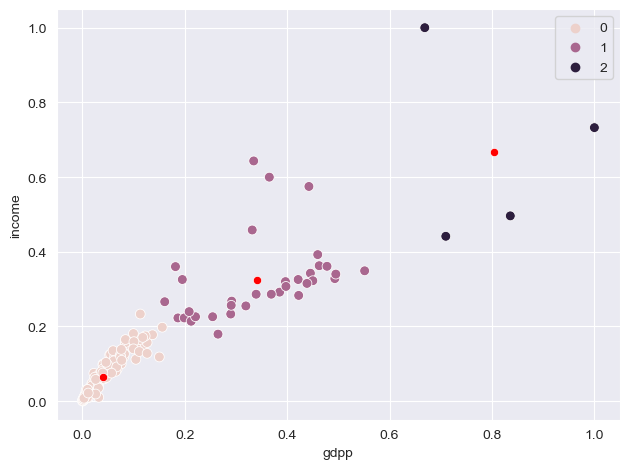

In [742]:

a , results["gdpp_income"]= cluster(data.copy(), "gdpp", "income", 2)


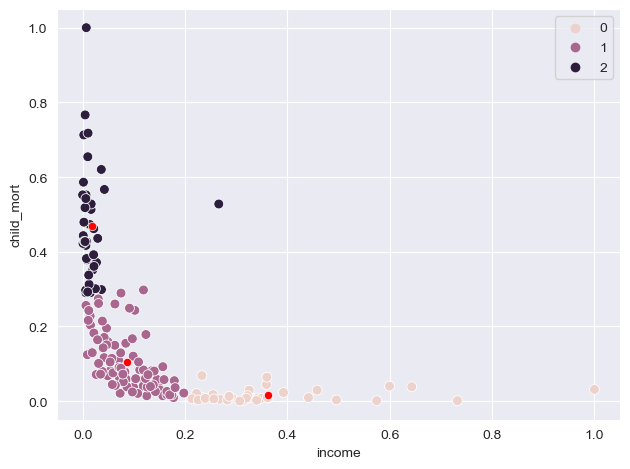

In [743]:

a, results["income_child_mort"]= cluster(data.copy(), "income", "child_mort", 2)
results.to_csv("result.csv", encoding='utf-8', index=False)

In [744]:
display(data_counrty)

,country,cluster_param_gdpp_child_mort
0,Afghanistan,1
1,Albania,2
2,Algeria,2
3,Angola,1
4,Antigua and Barbuda,2
...,...,...
162,Vanuatu,2
163,Venezuela,2
164,Vietnam,2
165,Yemen,2


In [745]:
import plotly.express as px

# test = data[["income", "gdpp"]]
def drow_map(data):

    fig = px.choropleth(data_frame=data,
                        locations="country",
                        locationmode="country names",
                        color=data.columns[1],
                        title="Clusters by country",
                        )
    fig.update_geos(showocean=True,
                    oceancolor="LightBlue",
                    )
    fig.show()


drow_map(data_counrty)

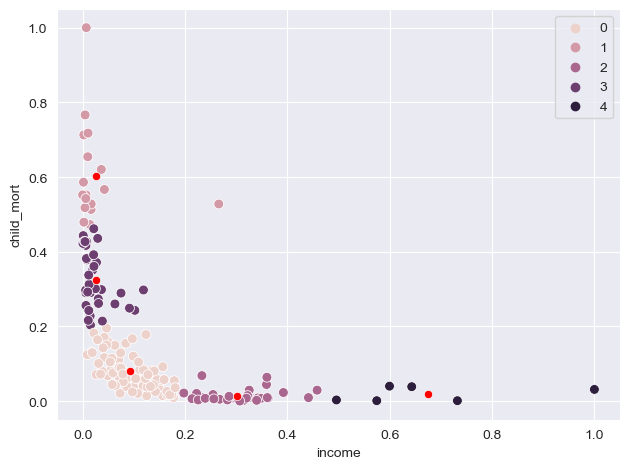

In [746]:
a, results["income_child_mort"]= cluster(data.copy(), "income", "child_mort", 2,count_cluster=5)
drow_map(a)